# DemoMA_MCClassifiction_CrowdAttention
### This demo shows an example of Multi-class classification with multiple annotators by using our model based on Deep Neural Networks with a new CrowdAttention layer to codify the information from multiple annotators.

In [1]:
import sys
from functools import partial
import warnings
import os
import sys

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics.cluster import normalized_mutual_info_score

import tensorflow as tf
import matplotlib.pyplot as plt
import random

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss, CategoricalCrossentropy

np.random.seed(0)
%matplotlib inline

## Some useful functions

In [2]:
# Clone the repo containig useful functions and the model
!git clone https://github.com/juliangilg/CCGPGCE.git
sys.path.append('/content/CCGPGCE')

Cloning into 'CCGPGCE'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 277.45 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
# Loading useful funtions
from utils import *

/content/CCGPGCE/utils.py:44: SyntaxWarning: invalid escape sequence '\c'
  1. For each annotator $r$, we compute a function $f_r(\cdot)$ as a combination


## 1. Multi-class classification problem definition

We assume a 1D multi-class classification problem, where input features are given as $x \in [0, 1]$ and the outputs are generated as follows

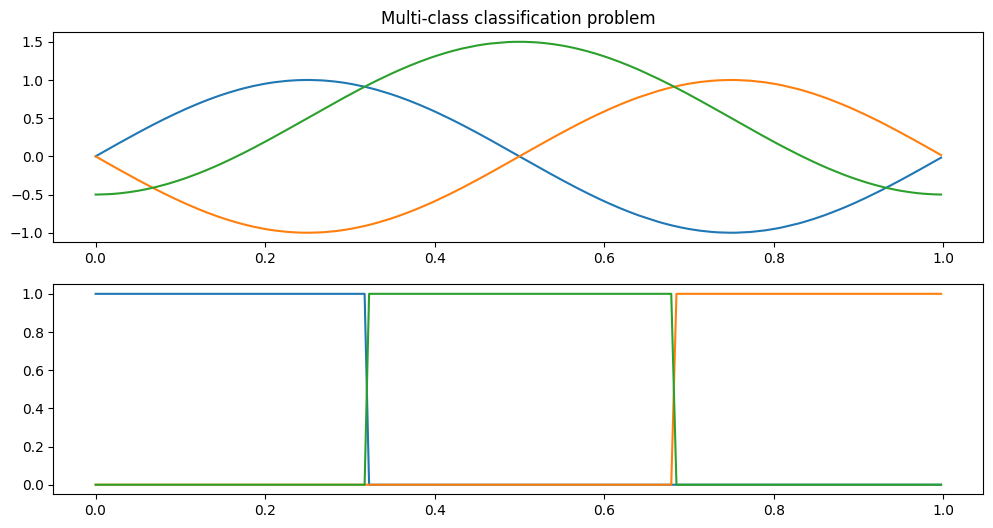

In [4]:
N = 300

np.random.seed(1)
X = np.random.rand(N,1)

t1 = (np.sin(2*np.pi*X)).reshape(N,1)
t2 = (-np.sin(2*np.pi*X)).reshape(N,1)
t3 = (-np.sin(2*np.pi*(X+0.25))+0.5).reshape(N,1)
t = np.concatenate((t1, t2, t3), axis=1)

idx = np.argsort(X, axis=0).flatten()
X = X[idx]
t = t[idx,:]
y = np.array(np.argmax(t, 1).reshape(-1,1), dtype=float)+1
K = len(np.unique(y))

# The true labels in codification 1-of-K
Yhat = one_of_K(y, K)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(X, t)
plt.title('Multi-class classification problem')
plt.subplot(2,1,2)
plt.plot(X, Yhat)
plt.show()

To define the training set, we randomly obtain $N=100$ samples from the interval $[0, 1]$. Conversely, for the test set, we sample uniformly $200$ points from $[0, 1]$

In [5]:
seed = 1
np.random.seed(seed)
Ntest = 200

# The training set
Xtrain = X
Xtrain = Xtrain.reshape((N,1))
ytrain = y

# The test set
Xtest = np.linspace(0, 1, Ntest).reshape((Ntest,1))
t1 = (np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t2 = (-np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t3 = (-np.sin(2*np.pi*(Xtest+0.25))+0.5).reshape(Ntest,1)
ttest = np.concatenate((t1, t2, t3), axis=1)
ytest = np.array(np.argmax(ttest, 1).reshape(-1,1), dtype=float)+1

## 2. Multiple annotators simulation

To simulate labels from multiple annotators, we assume them to correspond to corrupted versions of the ground truth. Thus, the labels are simulated by following approach:
1. For each annotator $r$, we compute a function $f_r(\cdot)$ as a combination of $Q$ deterministic functions $u_q(\cdot)$, with $q\in\{1, \dots , Q\}$.
2. We compute the annotators' reliability $\lambda_{r}(\cdot) = \sigma({f_r(\cdot)})$, where $\sigma(\cdot)$ is the Sigmoid function
$$\sigma(\cdot) = \frac{1}{1 + e^{-f_r(\cdot)}}.$$
3. If $\lambda_{r,n}>0.5$, $y_n^r=y_n$, and $y_n^r=\tilde{y}_n$ if $\lambda_{r,n}\le 0.5$, where $\tilde{y}_n$ is the flipped version of $y_n$

First, we define the some parameters related to the labelers

In [6]:
R = 5 # Number of annotators
NrP = 1.0 # the percentage of samples labeled by each annotator

Z_r, Ytrain, iAnn, Vref = multiple_annotators(R, NrP, Xtrain, ytrain)

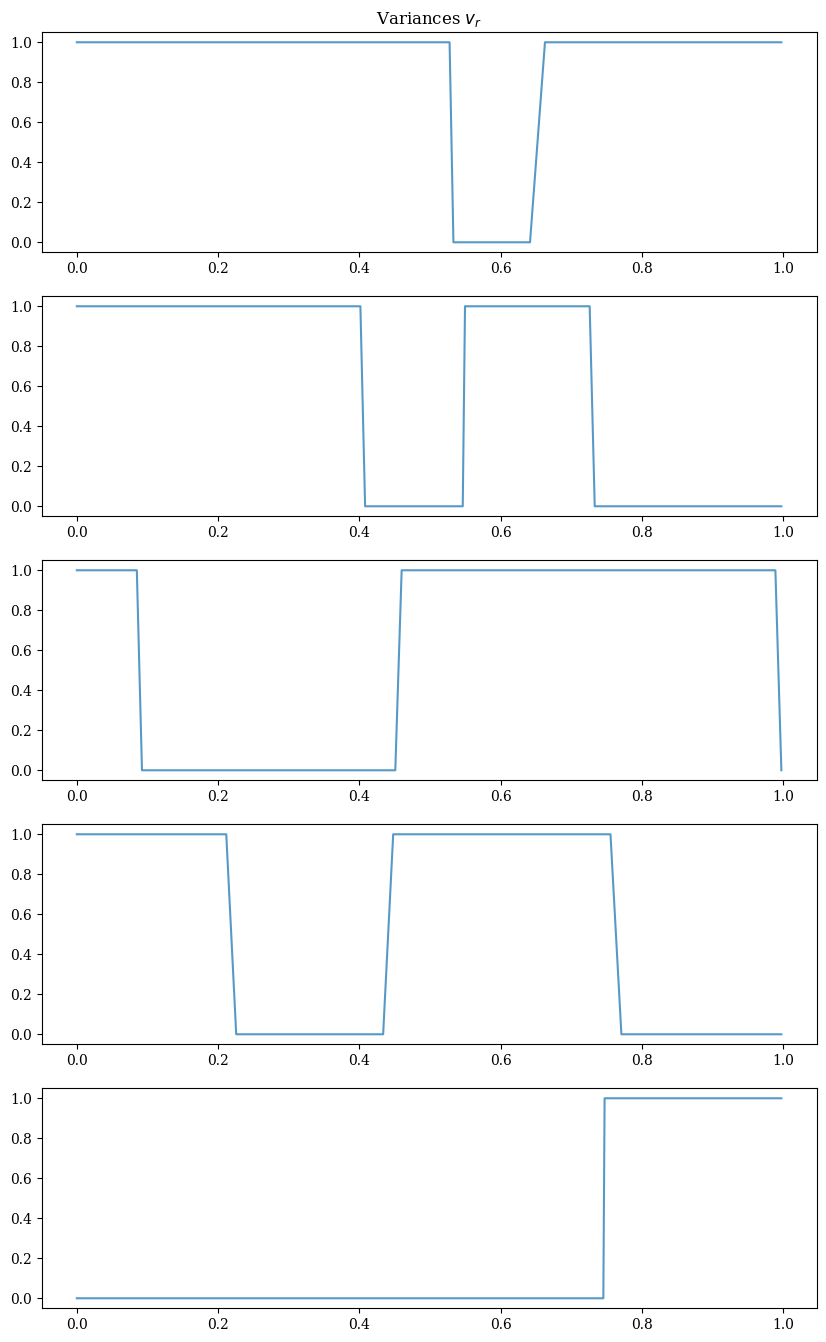

In [7]:
# We plot the annotators reliability as a function of the input features

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.figure(figsize=(10, 20))
for r in range(R):
    #Plots
    plt.subplot(6,1,r+1)
    plt.plot(Xtrain, Z_r[r], alpha=0.75, label='$v_'+str(r+1)+'$')
plt.subplot(6,1,1)
plt.title(r'Variances $v_r$')
plt.show()

In [8]:
#annotators performance
Acc = np.zeros((R+1,1))
for r in range(R):
    Acc[r,:] = accuracy_score(ytrain, Ytrain[:,r])
Acc[-1,:] = accuracy_score(ytrain, MAjVot(Ytrain, K))
NameCol = ['Accuracy']
NameIdx = ['Annotator_1','Annotator_2','Annotator_3','Annotator_4','Annotator_5','MajorityVoting']
Per = pd.DataFrame(Acc, columns =NameCol, index=NameIdx)
Per

,Accuracy
Annotator_1,0.846667
Annotator_2,0.596667
Annotator_3,0.663333
Annotator_4,0.556667
Annotator_5,0.276667
MajorityVoting,0.833333


## 3. Ground Truth

We evaluate the perofmance of a Deep Neural Netwotk by using the Ground Truth. Note that this outcome it is considered as the theoretical Upper Bound for our CrowdAttention.

In [9]:
def model(K, P):
  X = tf.keras.layers.Input(shape=(P,)) # Inputs
  neurons = 128
  # Classification Layer
  # 1. Input Embedings
  initializer = tf.keras.initializers.GlorotNormal(seed=100)
  q1 = tf.keras.layers.Dense(neurons, activation='relu', kernel_initializer=initializer)(X)
  q2 = tf.keras.layers.Dense(int(neurons/2), activation='relu', kernel_initializer=initializer)(q1)
  y_hat = tf.keras.layers.Dense(K, activation='softmax', kernel_initializer=initializer)(q2)
  model = Model(inputs=X, outputs=y_hat)
  return model

In [10]:
batch_size = 100
train_GT = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain-1))
train_GT = train_GT.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
model = model(K, 1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_GT, epochs=500)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1136
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1002
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0935
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0885
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0823
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0791
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0723
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0698
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0684
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0606
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0583
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0532
Epoch 13/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0504
Epoch 14/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0478
Epoch 15/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0410
Epoch 16/500
3/3 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


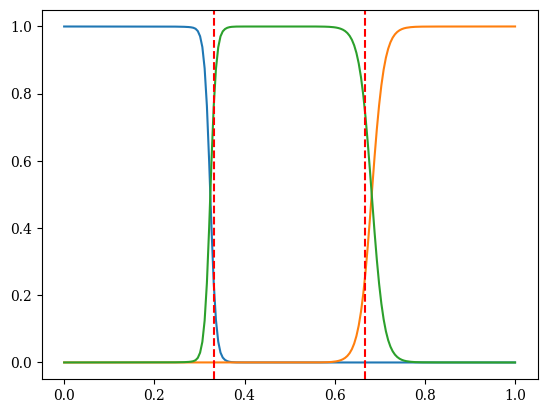

In [11]:
# We plot the predictions per class.

y_pred = model.predict(Xtest)
plt.plot(Xtest, y_pred)
# Add vertical lines at 1/3 and 2/3
plt.axvline(x=1/3, color='r', linestyle='--', label='1/3 boundary')
plt.axvline(x=2/3, color='r', linestyle='--', label='2/3 boundary')

## 4. Majority Voting

We train a second DNN, this time using the majority voting extracted from multiple annotators. We remark that such model in the naivests and it corresponds to the theoretical Lower Bound.

In [12]:
def model_1(K, P):
  X = tf.keras.layers.Input(shape=(P,)) # Inputs
  neurons = 128
  # Classification Layer
  # 1. Input Embedings
  initializer = tf.keras.initializers.GlorotNormal(seed=100)
  q1 = tf.keras.layers.Dense(neurons, activation='relu', kernel_initializer=initializer)(X)
  q2 = tf.keras.layers.Dense(int(neurons/2), activation='relu', kernel_initializer=initializer)(q1)
  y_hat = tf.keras.layers.Dense(K, activation='softmax', kernel_initializer=initializer)(q2)
  model = Model(inputs=X, outputs=y_hat)
  return model

In [13]:
batch_size = 100
ytran_hat = MAjVot(Ytrain, K)
train_GT = tf.data.Dataset.from_tensor_slices((Xtrain, ytran_hat-1))
train_GT = train_GT.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
model = model_1(K, 1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_GT, epochs=500)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1186
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1091
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1009
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0948
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0889
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0838
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0808
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0772
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0714
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0660
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0632
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0567
Epoch 13/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0516
Epoch 14/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0499
Epoch 15/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0406
Epoch 16/500
3/3 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


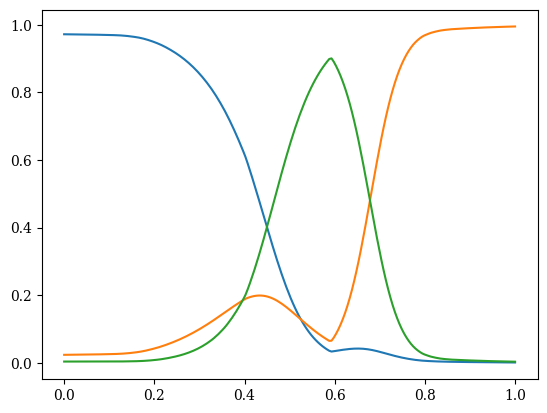

In [14]:
y_pred = model.predict(Xtest)
plt.plot(Xtest, y_pred)

## 5. CrowdAttention


In [15]:
# Clone the repo containig useful functions and the model
!git clone https://github.com/juliangilg/CrowdAttention.git
sys.path.append('/content/CrowdAttention')

Cloning into 'CrowdAttention'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 6.45 KiB | 6.45 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [16]:
from crowdattention import CrowdAttentionLayer
from crowdattention import CrowdAttentionLoss

In [17]:
# We define the DNN that gives an estmation of the hidden ground truth.

class ClassificationLayer(Layer):
  def __init__(self, P, K, neurons, **kwargs):
      super(ClassificationLayer, self).__init__(**kwargs)
      self.P = P
      self.M = neurons
      self.K = K
      self.q1 = tf.keras.layers.Dense(self.M, activation='relu')
      self.q2 = tf.keras.layers.Dense(int(self.M/2), activation='relu')
      self.q3 = tf.keras.layers.Dense(int(self.M/4), activation='relu')
      self.y_hat_layer = tf.keras.layers.Dense(self.K, activation='softmax')

  def call(self, X):
      q1 = self.q1(X)
      q2 = self.q2(q1)
      q3 = self.q3(q2)
      y_hat = self.y_hat_layer(q2)

      return y_hat

In [18]:
class model_CA():
  def __init__(self, P, K, R, neurons):
    self.P = P
    self.K = K
    self.R = R
    self.neurons = neurons

  def build_model(self):
    # Defining multiple inputs
    X = tf.keras.layers.Input(shape=(self.P,)) # Inputs
    Y = tf.keras.layers.Input(shape=(self.R,)) # Crowd

    # Classification Layer
    y_hat = ClassificationLayer(self.P, self.K, self.neurons)(X)

    # CrowdLayer
    y_tilde, lamb = CrowdAttentionLayer(self.K, self.R)(y_hat, Y)

    output = tf.keras.layers.Concatenate(axis=1)([y_hat, y_tilde, lamb])

    model = Model(inputs=[X, Y], outputs=output)
    return model

In [19]:
N = Xtrain.shape[0]
# Create a tf.data.Dataset with both Xtrain and Ytrain
batch_size = 100  # Set your desired batch size
dataset = tf.data.Dataset.from_tensor_slices(((Xtrain, Ytrain), Ytrain)) # Output is also Ytrain for the CrowdAttentionLoss
train_dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
def scheduler1(step=50, ratio=1.5):
  def scheduler(epoch, lr):
      if epoch % step == 0 and epoch > 1:
          return lr / ratio
      else:
          return lr
  return scheduler

callback = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio=1.2))

In [21]:
model = model_CA(1, K, R, 512).build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss=CrowdAttentionLoss(K,R))

In [22]:
epochs = 600  # Set your desired number of epochs
history = model.fit(train_dataset, epochs=epochs, callbacks=[callback])

Epoch 1/600


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['classification_layer/dense_8/kernel', 'classification_layer/dense_8/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0010 - learning_rate: 0.0020
Epoch 2/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7784 - learning_rate: 0.0020
Epoch 3/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4639 - learning_rate: 0.0020
Epoch 4/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3967 - learning_rate: 0.0020
Epoch 5/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3653 - learning_rate: 0.0020
Epoch 6/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2842 - learning_rate: 0.0020
Epoch 7/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3767 - learning_rate: 0.0020
Epoch 8/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1732 - learning_rate: 0.0020
Epoch 9/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1381 - learning_rate: 0.0020
Epoch 10/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8214 - learning_rate: 0.0020
Epoch 11/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8660 - learning_rate: 0.0020
Epoch 12/600
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4

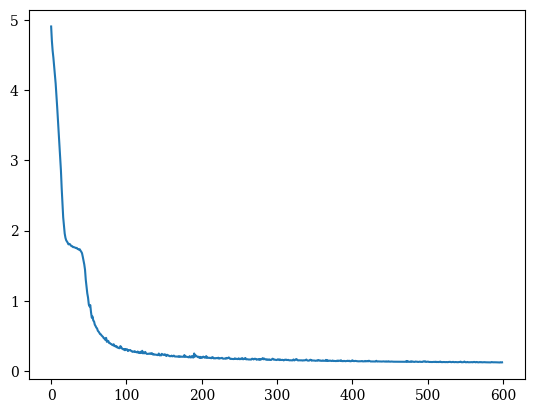

In [23]:
plt.plot(history.history['loss'])

In [24]:
Ntest = Xtest.shape[0]
A = model.predict((Xtrain, Ytrain))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [25]:
y_pred = A[:,:K]
y_tilde = A[:,K:2*K]
lamb = A[:,2*K:]

0.9833333333333333


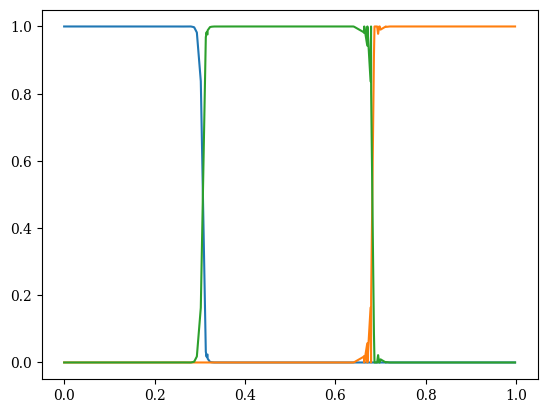

In [26]:
plt.plot(Xtrain, y_tilde)

auxMc = np.array(np.argmax(y_pred, 1).reshape(-1,1), dtype=float)+1
F1_CCGP = f1_score(ytrain.flatten(), auxMc.flatten(),average='micro')
print(F1_CCGP)

## 5. Figures  and Perfomance assessment

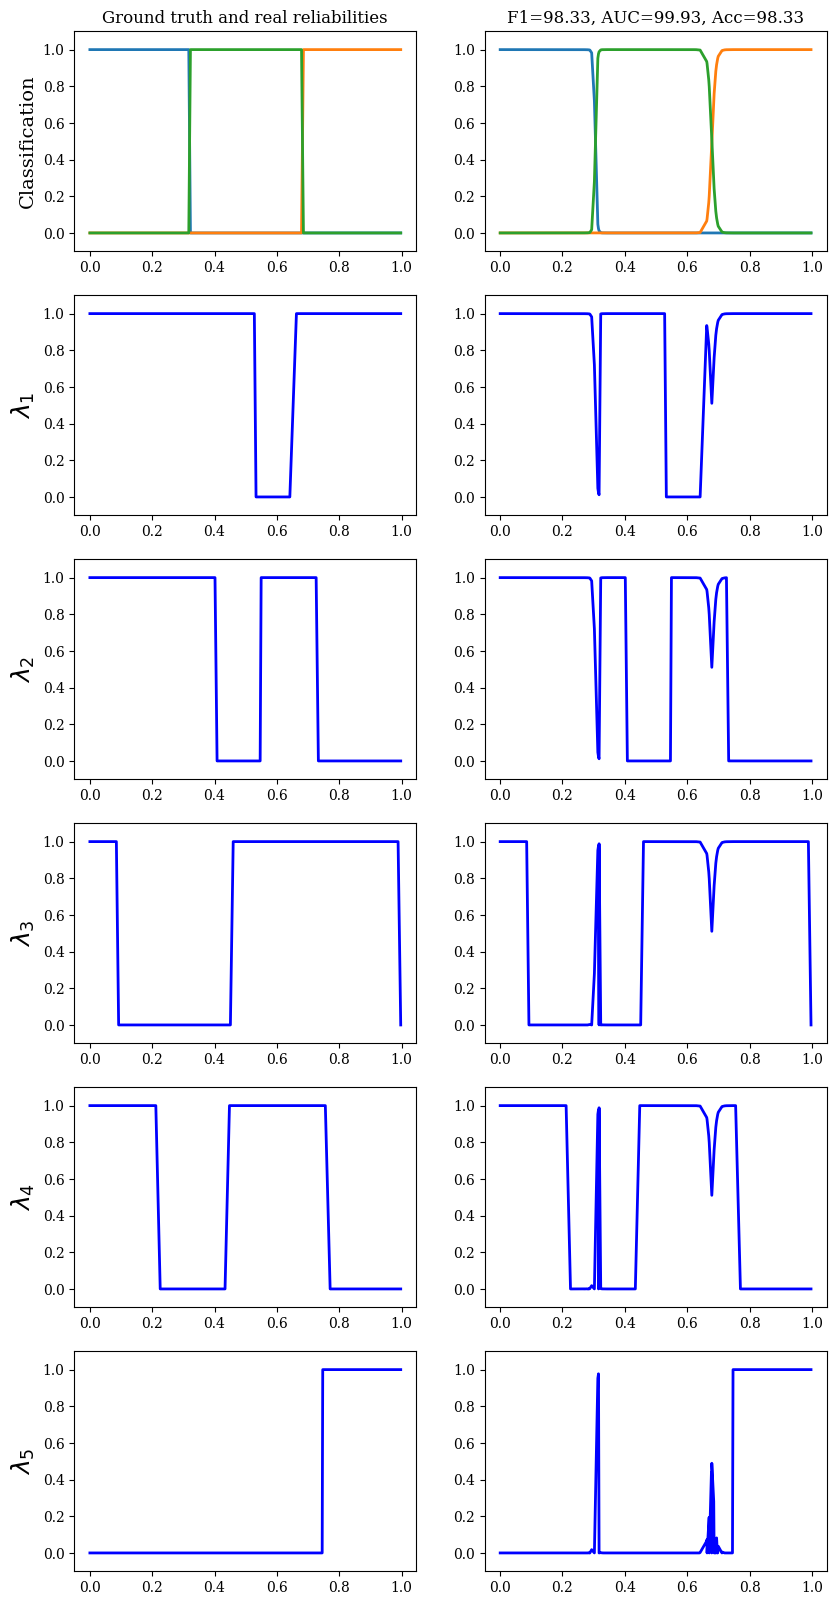

In [27]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.figure(figsize=(15, 20))

Mc = np.concatenate((y_pred, lamb), axis=1)
Yhat = one_of_K(ytrain, K)

for r in range(R+1):
    # Original Values
    miny = 0
    maxy = 1
    if r ==0:
        plt.subplot(R+1,3, 3*r+1)
        plt.plot(Xtrain, Yhat, linewidth=2, alpha=1)
        plt.ylabel("Classification",fontsize=14)
        plt.ylim(miny-0.1, maxy+0.1)
    else:
        plt.subplot(R+1,3, 3*r+1)
        plt.plot(Xtrain, Z_r[r-1], 'b-', linewidth=2, alpha=1)
        plt.ylabel(r"$"+r"\lambda_"+str(r)+'$', fontsize=18)
        plt.ylim(-0.1, 1.1)

    # CGP
    if r > 0:
        mfc = Mc[:, K+r-1]

        plt.subplot(R+1,3, 3*r+2)
        plt.plot(Xtrain, (mfc), 'b-', linewidth=2, alpha=1)
        plt.ylim(miny-0.1, maxy+0.1)
    else:
        mfc = Mc[:, :K]

        plt.subplot(R+1,3, 3*r+2)
        plt.plot(Xtrain, (mfc), linewidth=2, alpha=1)
        plt.ylim(miny-0.1, maxy+0.1)




# Regression performance
auxMc = np.array(np.argmax(Mc[:,:K], 1).reshape(-1,1), dtype=float)+1


AccCCGP  = accuracy_score(ytrain, auxMc)
AUC_CCGP = roc_auc_score(Yhat, Mc[:,:K])
F1_CCGP = f1_score(ytrain.flatten(), auxMc.flatten(),average='micro')

plt.subplot(R+1,3,1)
plt.title('Ground truth and real reliabilities')
plt.subplot(R+1,3,2)
plt.title('F1='+"{:.2f}".format(F1_CCGP*100)+', AUC='+"{:.2f}".format(AUC_CCGP*100)+', Acc='"{:.2f}".format(AccCCGP*100))
plt.savefig('output.pdf')
plt.show()

